<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 
    20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  PROJECT 2: Decision Tree
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Online Shopper Dataset 

</div>

#### Tập dữ liệu: [Online Shoppers Purchasing Intention Dataset] 
- link: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset?fbclid=IwY2xjawHGbTVleHRuA2FlbQIxMAABHYzxo-CmR9oI1Ph1rmPzPDCjOzGgByZmvipoIhY2rb4OIjUXTMXewp-6hw_aem_-04k_qWJvfJVyqR-ZYxEqg
---

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os

## 2. Specifications
### 2.1 Preparing the datasets
#### 2.1a Chia dataset

Sử dụng các đặc điểm và nhãn ở trên, vui lòng chuẩn bị bốn tập hợp con sau:
- feature_train: tập hợp các mẫu huấn luyện.
- label_train: tập hợp các nhãn tương ứng với các mẫu trong feature_train.
- feature_test: một tập hợp các mẫu thử nghiệm có cấu trúc feature_train.
- label_test: tập hợp các nhãn tương ứng với các mẫu trong feature_test.

Quá trình chia dữ liệu:
- Xáo trộn tập dữ liệu trước khi chia tách và đảm bảo nó được phân chia theo kiểu phân tầng.
- Các tham số khác (nếu có) sẽ giữ nguyên ở cài đặt mặc định.
- Sẽ có các thí nghiệm trên tập huấn luyện và tập kiểm tra với các tỷ lệ khác nhau, bao gồm 40/60,
60/40, 80/20 và 90/10 (luyện tập/kiểm tra);

In [2]:
file_path = "online_shoppers_intention.csv" 
data = pd.read_csv(file_path)
data = pd.get_dummies(data, columns=['VisitorType', 'Month', 'Weekend'], drop_first=True)
X = data.drop(columns=['Revenue'])
y = data['Revenue']
data_splits = {}

split_ratios = [0.4, 0.6, 0.8, 0.9] 
test_ratios = [1 - ratio for ratio in split_ratios]  

for train_ratio, test_ratio in zip(split_ratios, test_ratios):
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y, 
        test_size=test_ratio, 
        stratify=y, 
        random_state=42,  
        shuffle=True     
    )
    key = f"{int(round(train_ratio * 100))}_{int(round(test_ratio * 100))}"  
    data_splits[key] = {
        "feature_train": feature_train,
        "label_train": label_train,
        "feature_test": feature_test,
        "label_test": label_test
    }

for split_key, split_data in data_splits.items():
    print(f"Split {split_key}:")
    print(f"  Training set: {split_data['feature_train'].shape}")
    print(f"  Test set: {split_data['feature_test'].shape}")
    print()


Split 40_60:
  Training set: (4932, 26)
  Test set: (7398, 26)

Split 60_40:
  Training set: (7398, 26)
  Test set: (4932, 26)

Split 80_20:
  Training set: (9864, 26)
  Test set: (2466, 26)

Split 90_10:
  Training set: (11097, 26)
  Test set: (1233, 26)



#### 2.1b Trực quan hóa sự phân bố lớp trong tất cả các tập dữ liệu

Trực quan hóa sự phân bố của lớp trong tất cả các tập dữ liệu (tập gốc, tập huấn luyện và tập kiểm tra)
trên tất cả các tỷ lệ để chứng minh rằng chúng đã được chuẩn bị phù hợp.

In [4]:
def draw_plot(column, original, train, test, title):
    """
    Draws a bar plot to compare the distribution of a specific column across original, train, and test sets.
    """
    labels = original.value_counts().index
    original_counts = original.value_counts().values
    train_counts = train.value_counts().reindex(labels, fill_value=0).values
    test_counts = test.value_counts().reindex(labels, fill_value=0).values

    x = range(len(labels))  # Indices for bar groups

    plt.figure(figsize=(10, 6))
    plt.bar(x, original_counts, width=0.3, label='original', color='orange', alpha=0.7)
    plt.bar([i + 0.3 for i in x], train_counts, width=0.3, label='train', color='green', alpha=0.7)
    plt.bar([i + 0.6 for i in x], test_counts, width=0.3, label='test', color='blue', alpha=0.7)

    plt.title(title)
    plt.xticks([i + 0.3 for i in x], labels, rotation=45, ha="right")
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

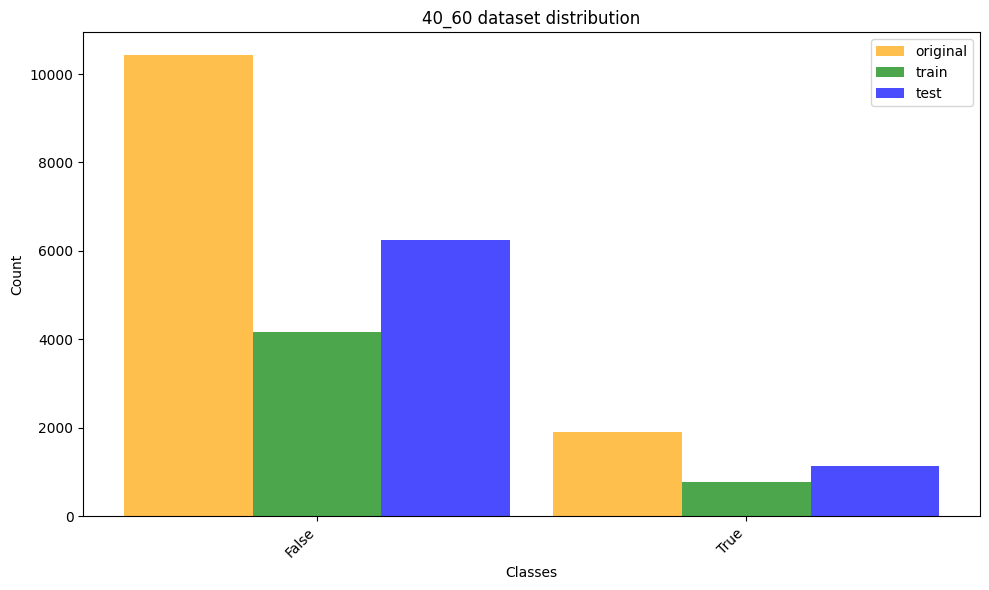

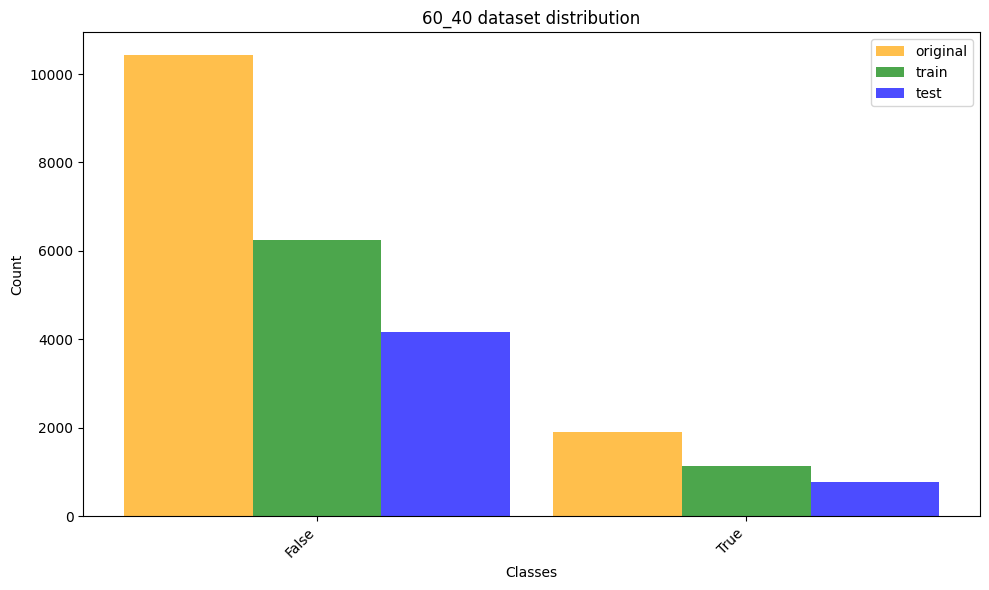

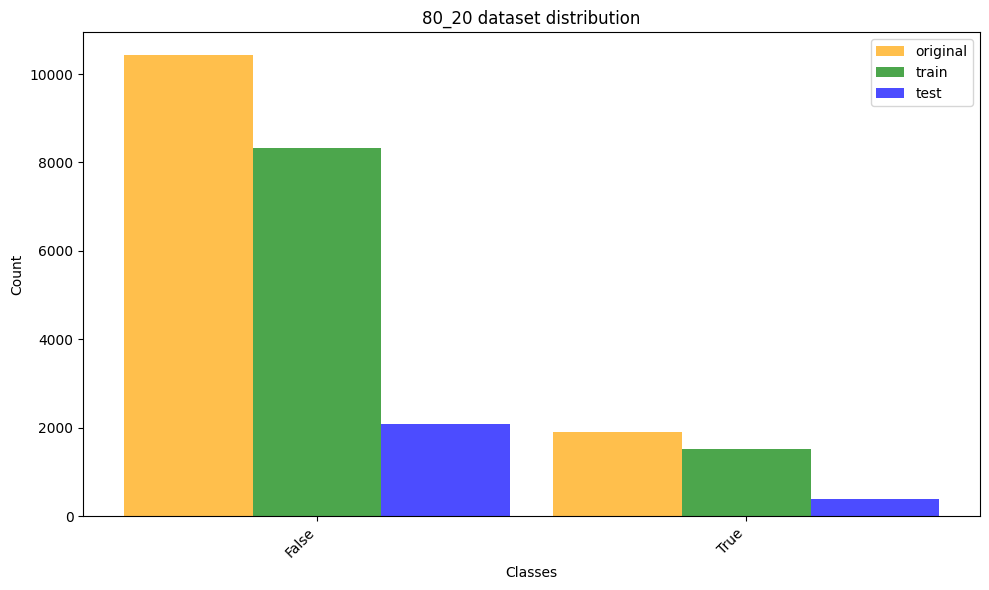

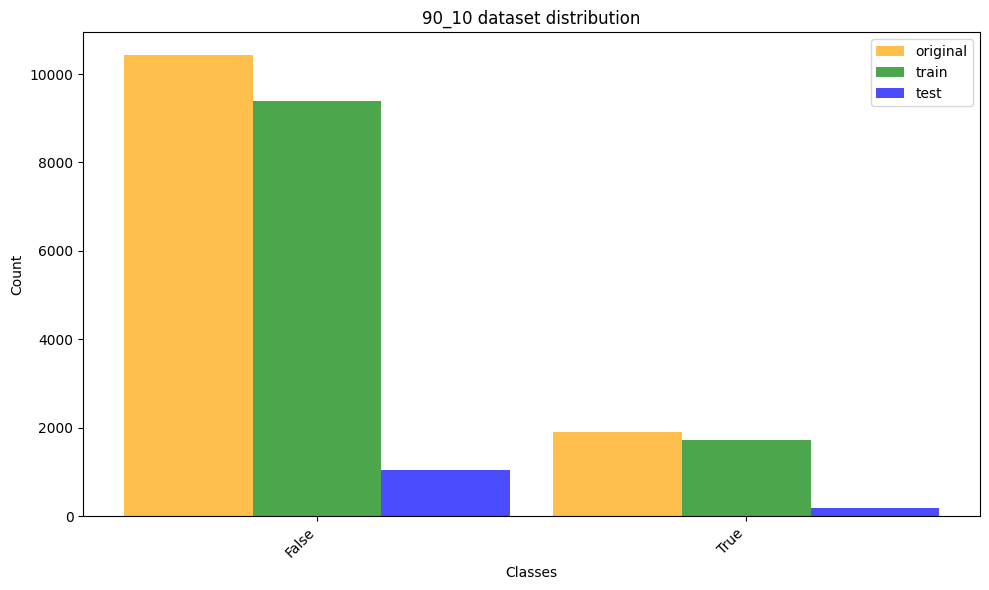

In [5]:
for split_key, split_data in data_splits.items():
    draw_plot(
        y, 
        y, 
        split_data['label_train'],  
        split_data['label_test'],   
        f"{split_key} dataset distribution"
    )

### 2.2 Building the decision tree classifiers

- Tiến hành các thí nghiệm trên tỷ lệ huấn luyện/thử nghiệm được chỉ định được liệt kê
- Sử dụng **sklearn.tree.DecisionTreeClassifier** cho từng tập huấn luyện và trực quan hóa cây quyết định kết quả bằng Graphviz.

In [6]:
def train_and_visualize_decision_tree(feature_train, label_train, feature_test, label_test, split_key):
    """
    Trains a DecisionTreeClassifier and visualizes the resulting decision tree.
    """
    output_dir = "Decision_Tree_Visualizations_Additional_Dataset"
    os.makedirs(output_dir, exist_ok=True)
    
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(feature_train, label_train)
    
    predictions = clf.predict(feature_test)
    accuracy = accuracy_score(label_test, predictions)
    print(f"Accuracy for {split_key} split: {accuracy:.4f}")
    
    dot_data = export_graphviz(
        clf,
        out_file=None,  
        feature_names=feature_train.columns,  
        class_names=clf.classes_.astype(str),  
        filled=True,  
        rounded=True,  
        special_characters=True  
    )
    
    graph = graphviz.Source(dot_data)

    output_file = f"decision_tree_{split_key}"
    graph.render(os.path.join(output_dir, output_file), format="svg",cleanup=True)
    print(f"Decision tree for {split_key} split saved to {output_file}")

for split_key, split_data in data_splits.items():
    train_and_visualize_decision_tree(
        feature_train=split_data['feature_train'],
        label_train=split_data['label_train'],
        feature_test=split_data['feature_test'],
        label_test=split_data['label_test'],
        split_key=split_key
    )

Accuracy for 40_60 split: 0.8598


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

### 2.3 Evaluating the decision tree classifiers

- Đối với mỗi phân loại cây quyết định, hãy dự đoán các mẫu trong bộ kiểm tra tương ứng và tạo báo cáo bằng cách sử dụng **classification_report** và **classification_report**.  

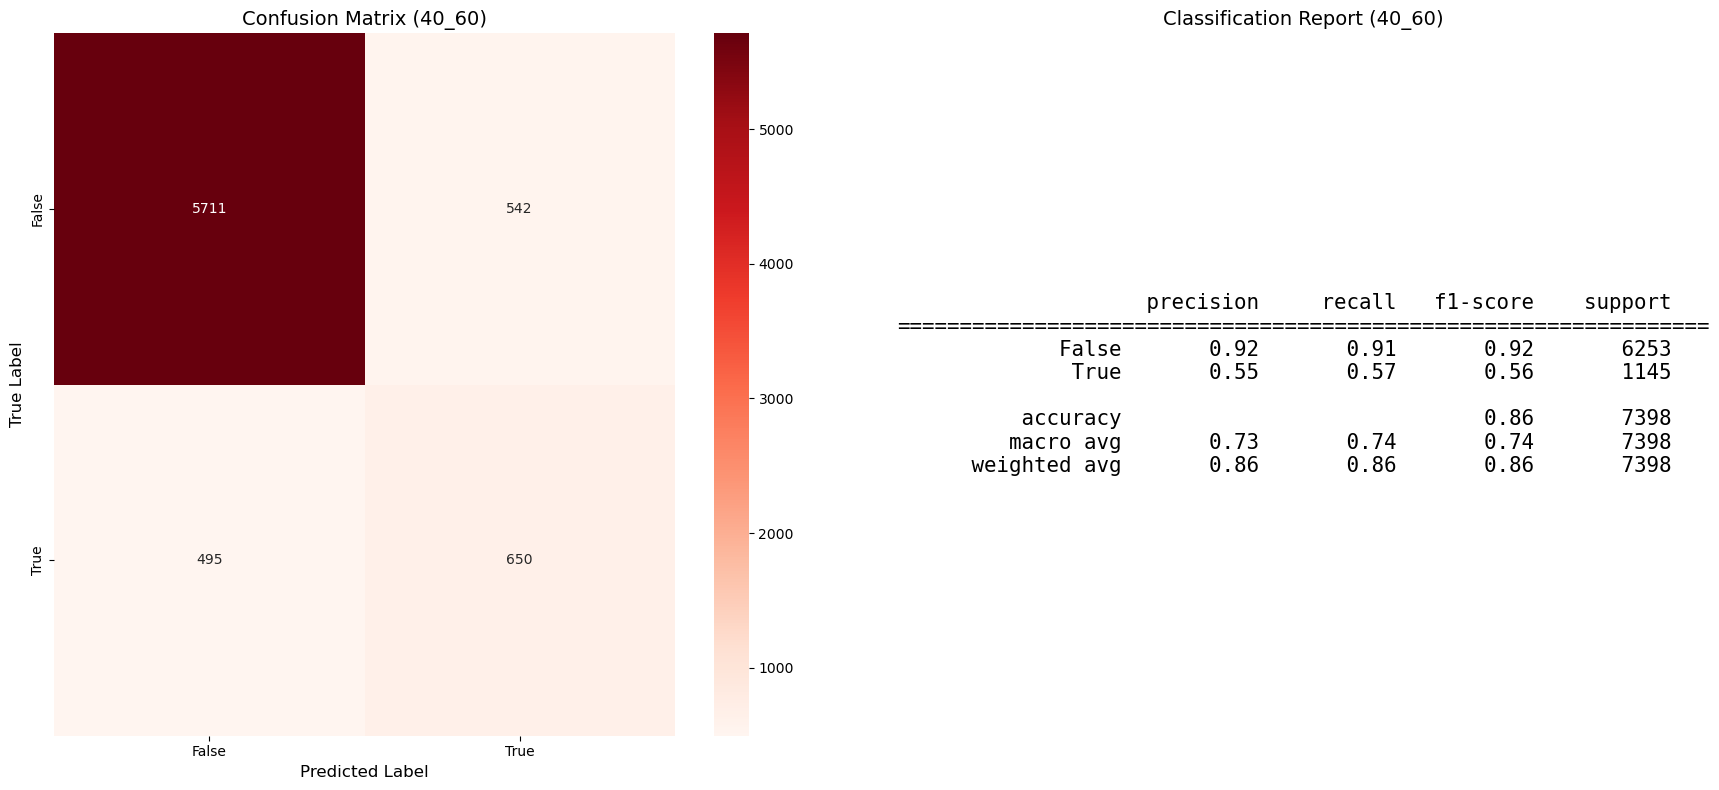

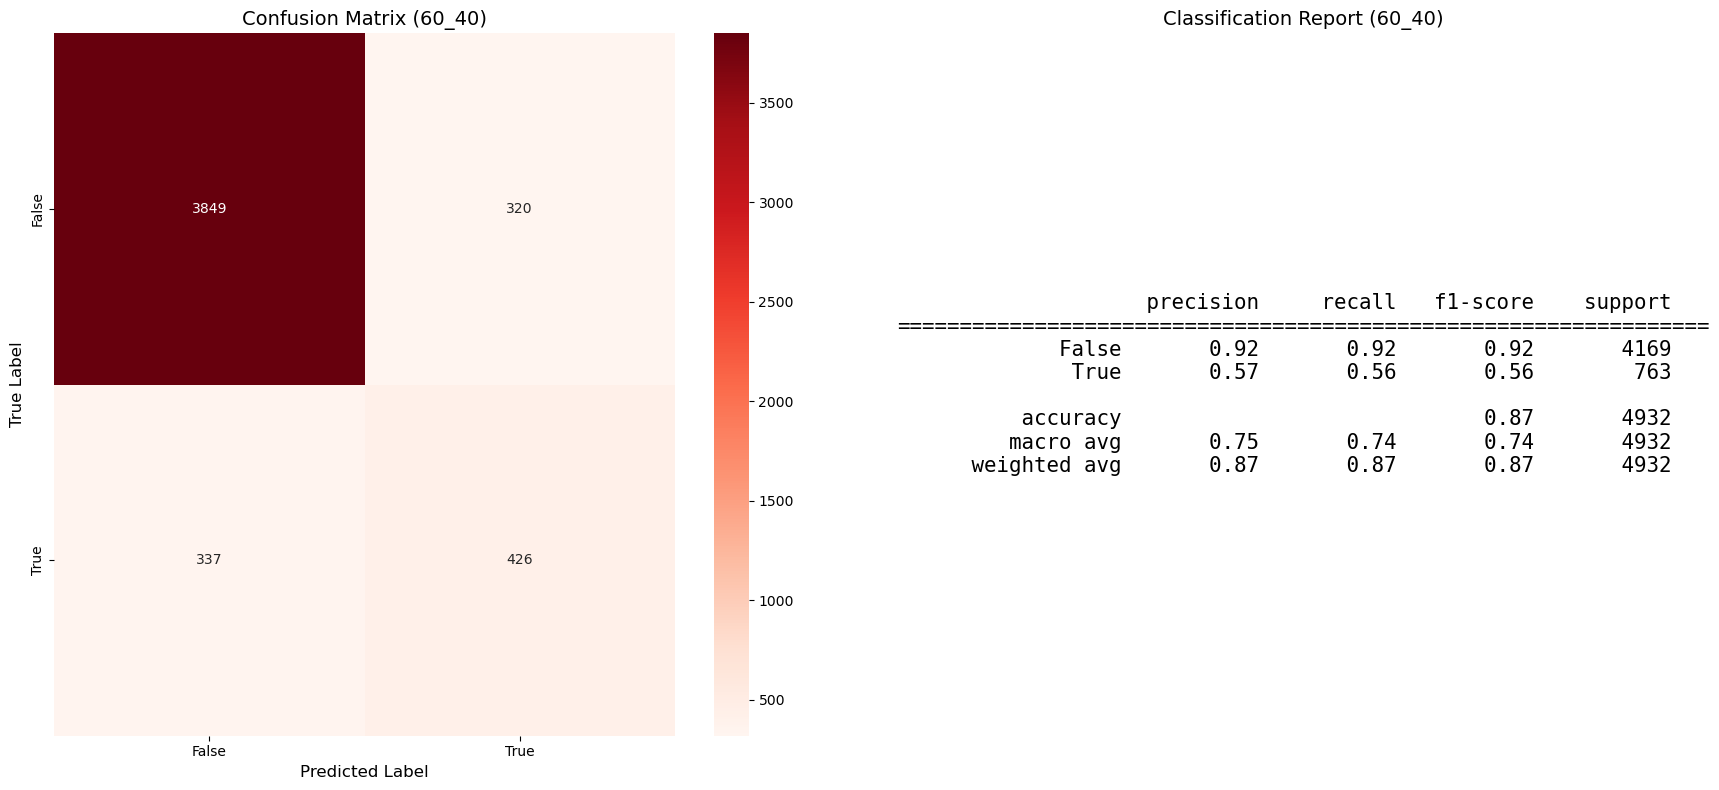

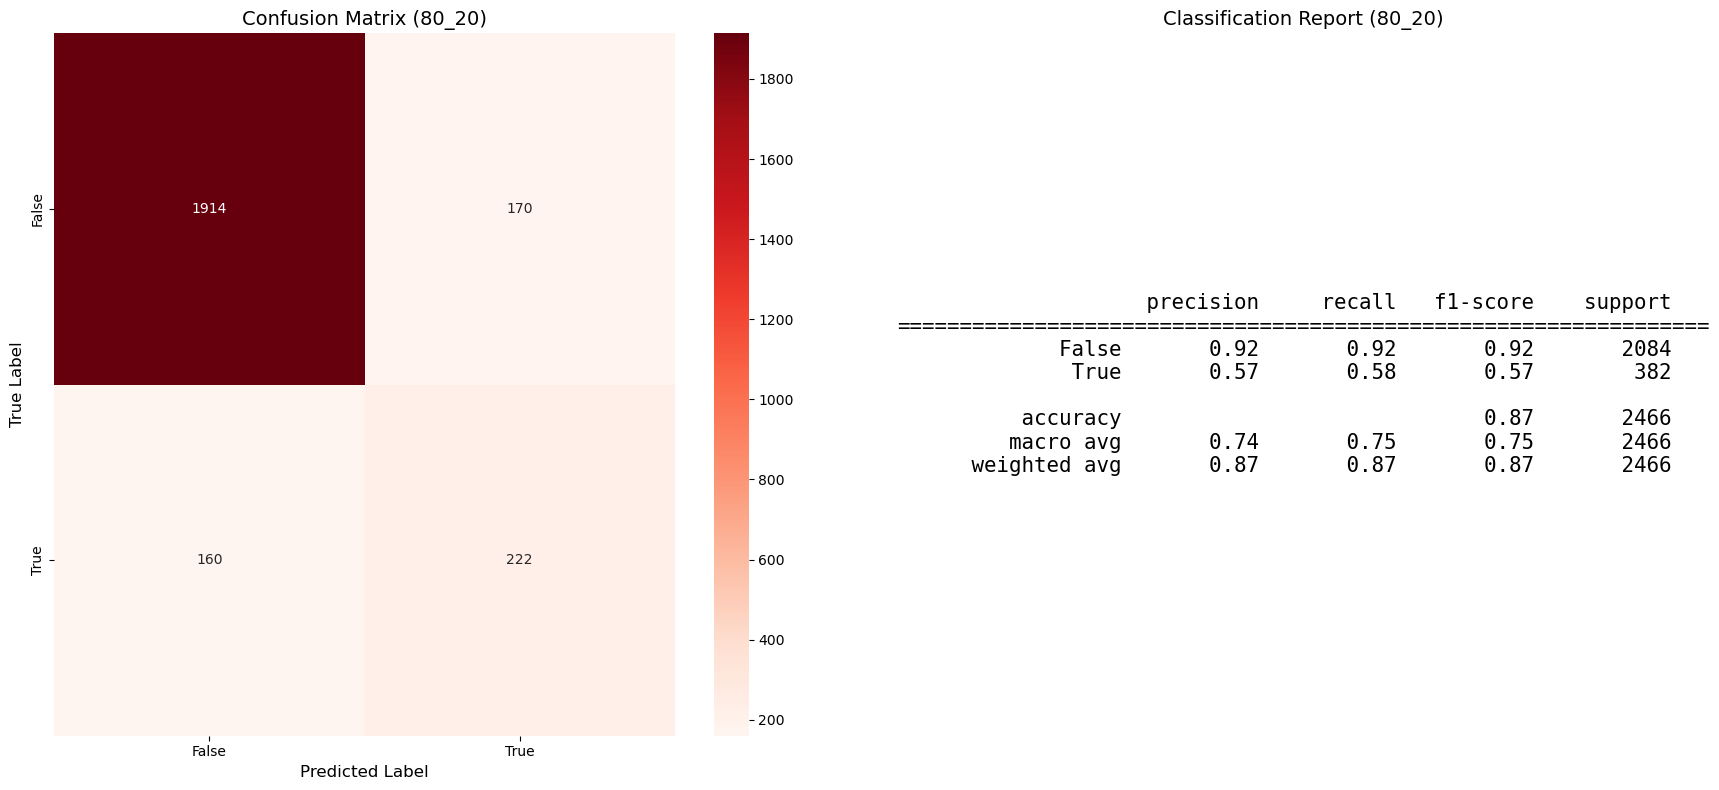

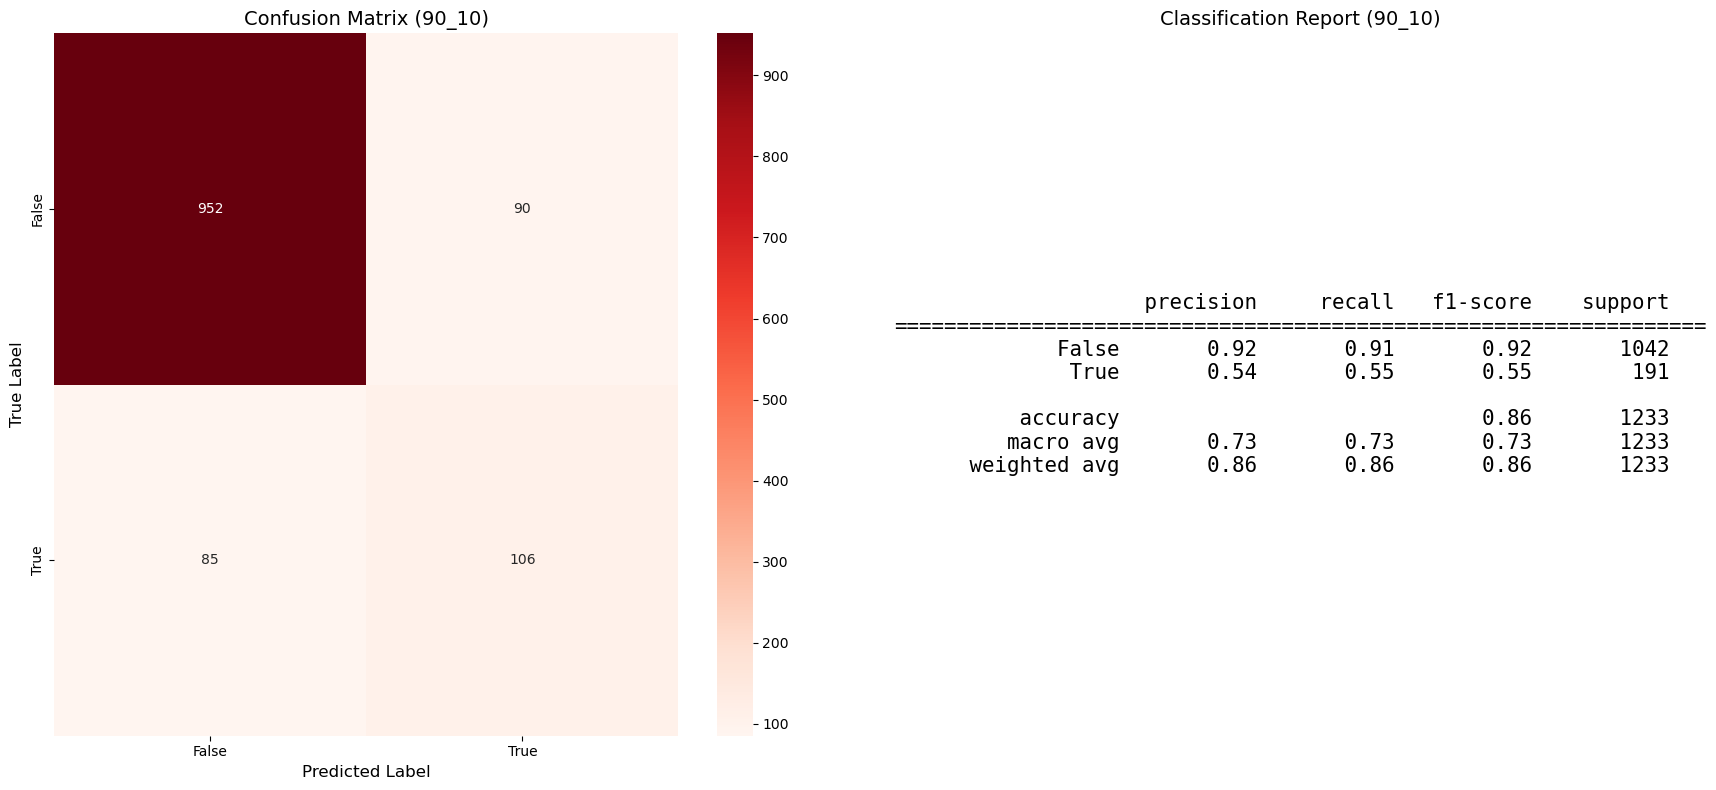

In [46]:
def plot_combined_report_and_matrix(cm, classes, report_dict, split_key):
    """
    Plots a classification report and a confusion matrix in a single figure.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_title(f"Confusion Matrix ({split_key})", fontsize=14)
    axes[0].set_xlabel("Predicted Label", fontsize=12)
    axes[0].set_ylabel("True Label", fontsize=12)

    # Classification Report
    axes[1].axis('off')
    report_text = classification_report_text(report_dict)
    axes[1].text(0.5, 0.5, report_text, fontsize=15, verticalalignment='center', horizontalalignment='center', family="monospace")
    axes[1].set_title(f"Classification Report ({split_key})", fontsize=14)

    plt.tight_layout()
    plt.show()

def classification_report_text(report_dict):
    """
    Generates a formatted text representation of a classification report.
    """
    headers = ["precision", "recall", "f1-score", "support"]
    lines = ["{:>15} {:>10} {:>10} {:>10} {:>10}".format("", *headers)]
    lines.append("=" * 65)

    for key, values in report_dict.items():
        if key not in ["accuracy", "macro avg", "weighted avg"]:
            metrics = [values.get(h, 0.0) for h in headers[:-1]] + [int(values.get("support", 0))]
            lines.append("{:>15} {:>10.2f} {:>10.2f} {:>10.2f} {:>10}".format(key, *metrics))
        elif key == "accuracy":
            support_sum = sum(v.get("support", 0) for k, v in report_dict.items() if k not in ["accuracy", "macro avg", "weighted avg"])
            lines.append("\n{:>15} {:>32.2f} {:>10}".format(key, values, support_sum))
        else:
            metrics = [values.get(h, 0.0) for h in headers[:-1]] + [int(values.get("support", 0))]
            lines.append("{:>15} {:>10.2f} {:>10.2f} {:>10.2f} {:>10}".format(key, *metrics))

    return "\n".join(lines)

def train_evaluate_visualize(feature_train, label_train, feature_test, label_test, split_key):
    """
    Trains a DecisionTreeClassifier, evaluates it, and visualizes results.
    """
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(feature_train, label_train)

    predictions = clf.predict(feature_test)

    report = classification_report(label_test, predictions, target_names=clf.classes_.astype(str), output_dict=True)
    cm = confusion_matrix(label_test, predictions, labels=clf.classes_)

    plot_combined_report_and_matrix(cm, classes=clf.classes_, report_dict=report, split_key=split_key)

    return report, cm

for split_key, split_data in data_splits.items():
    train_evaluate_visualize(
        feature_train=split_data['feature_train'],
        label_train=split_data['label_train'],
        feature_test=split_data['feature_test'],
        label_test=split_data['label_test'],
        split_key=split_key
    )


### 2.4 The depth and accuracy of a decision tree

- Sử dụng bộ train_test 80/20, cho biết độ sâu của cây quyết định ảnh hưởng đến độ chính xác của phân loại.
- Chỉ định độ sâu tối đa của cây quyết định bằng cách điều chỉnh tham số max_depth.
- Hãy thử các giá trị sau cho tham số max_depth: Không, 2, 3, 4, 5, 6, 7. Sau đó:
    - Cung cấp cây quyết định, được trực quan hóa bằng Graphviz, cho mỗi giá trị max_depth.
    - Báo cáo độ chính xác_score (trên bộ kiểm tra) của bộ phân loại cây quyết định cho từng giá trị của tham số max_depth.
    - Cung cấp biểu đồ và thông tin chi tiết của bạn về số liệu thống kê được báo cáo ở trên.

Accuracy for max_depth=None: 0.8662


Accuracy for max_depth=2: 0.8861


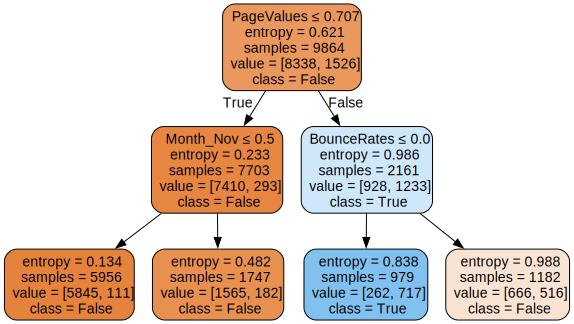

Accuracy for max_depth=3: 0.8978


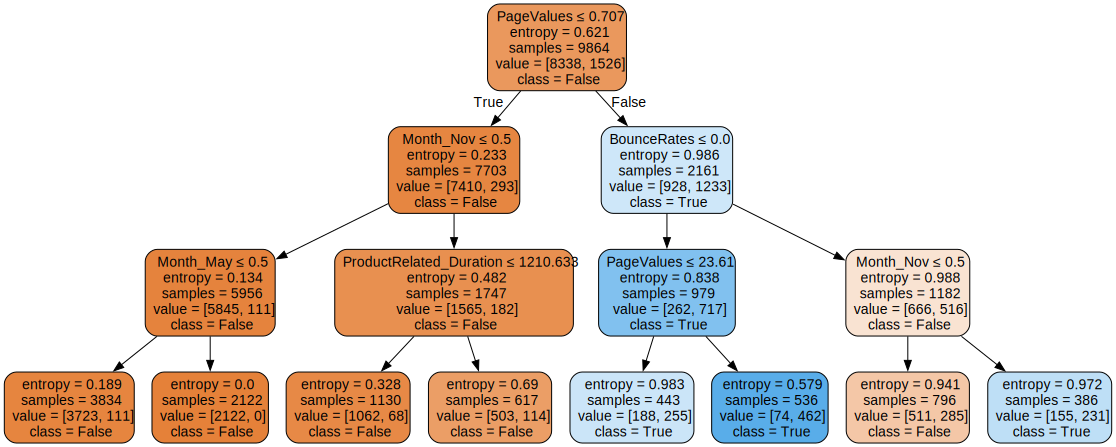

Accuracy for max_depth=4: 0.8974


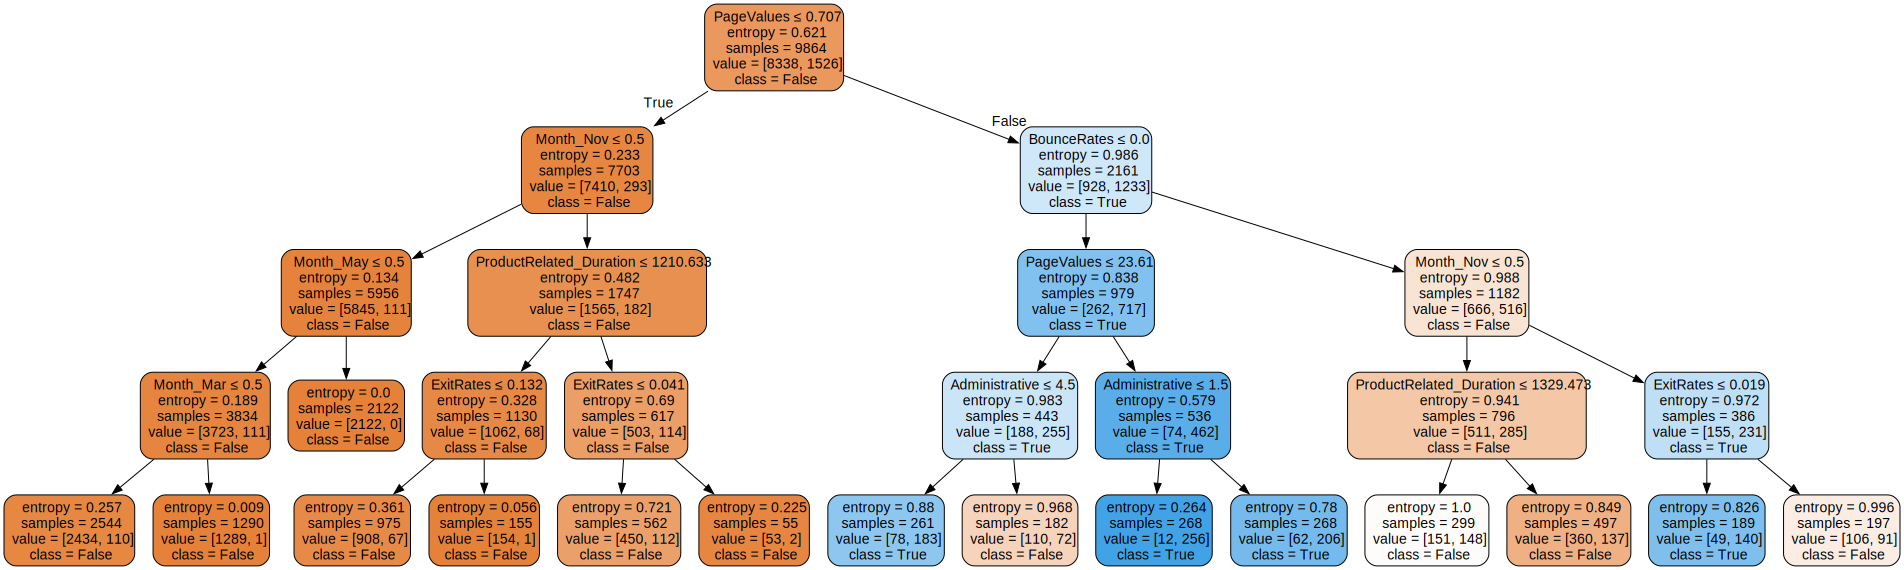

Accuracy for max_depth=5: 0.8970


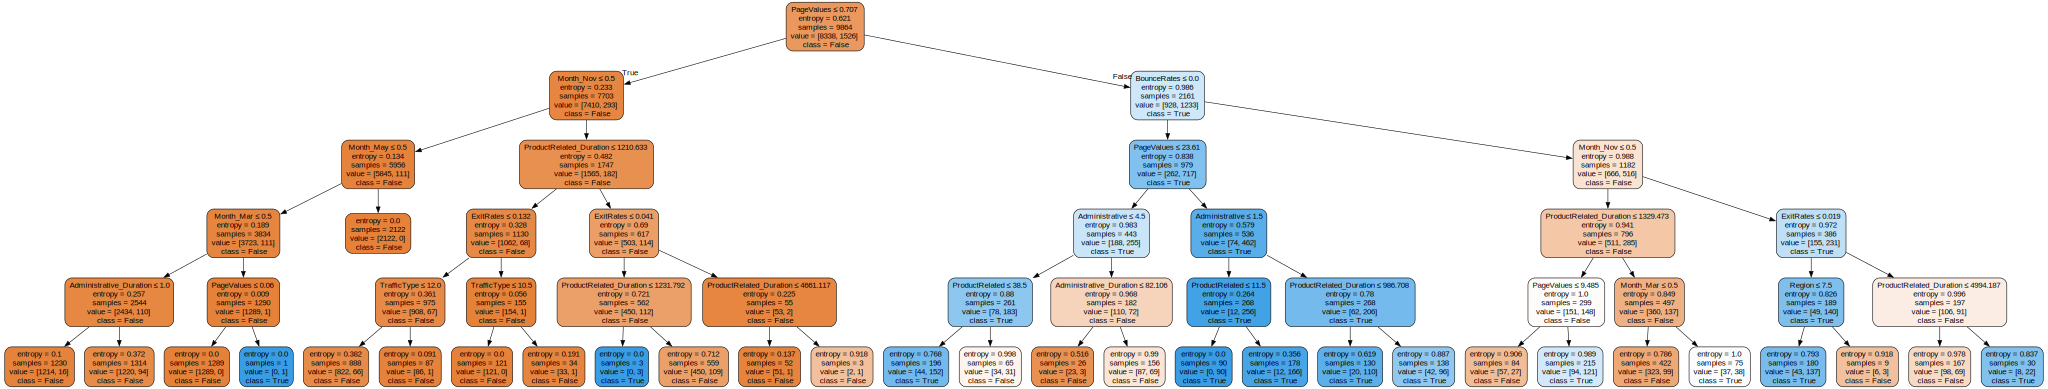

Accuracy for max_depth=6: 0.8954


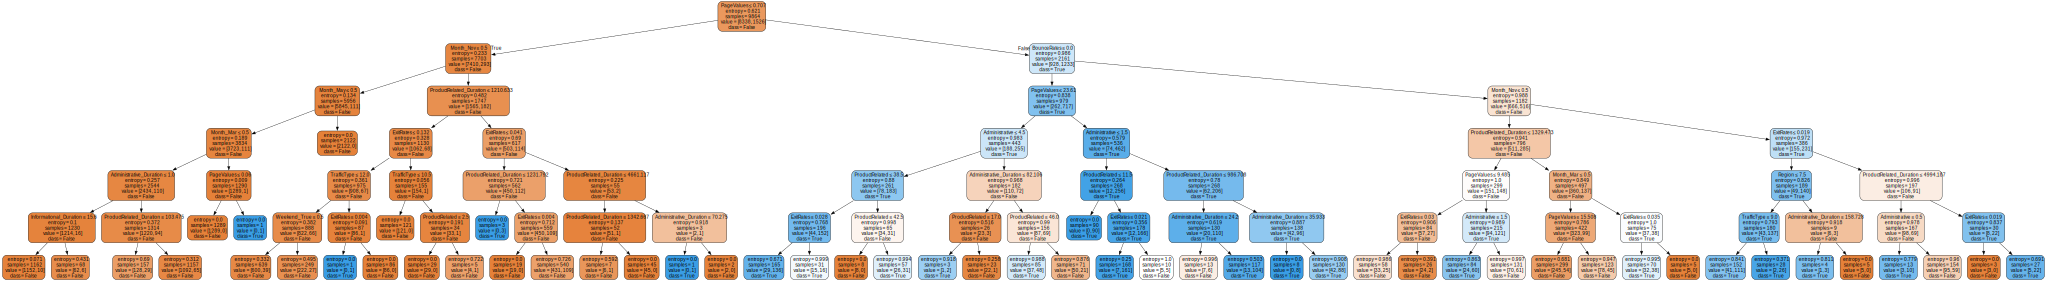

Accuracy for max_depth=7: 0.8917


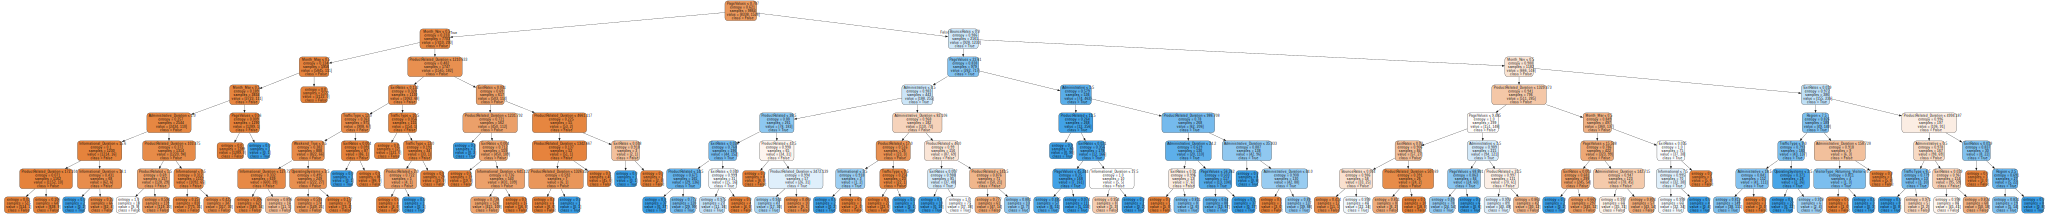

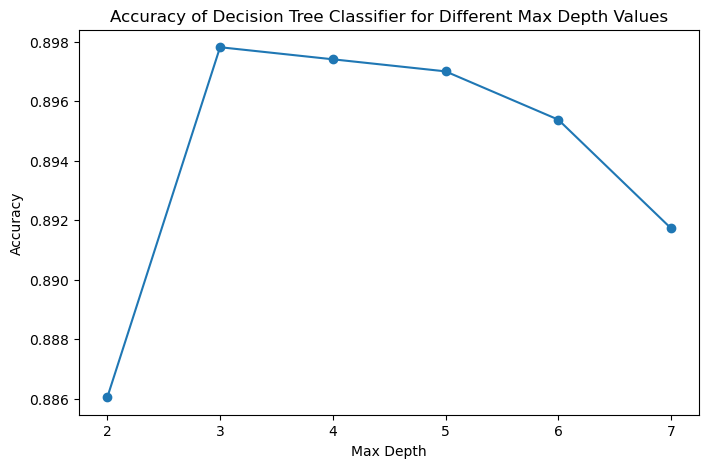

In [26]:
def train_visualize_depth(feature_train, label_train, feature_test, label_test):
    """
    Trains and visualizes decision trees with different max_depth values.
    """
    output_dir = "Decision_Tree_Visualizations_Additional_Dataset"
    os.makedirs(output_dir, exist_ok=True)
    max_depth_values = [None, 2, 3, 4, 5, 6, 7]
    accuracy_1=[]
    for depth in max_depth_values:
        clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=42)
        clf.fit(feature_train, label_train)

        predictions = clf.predict(feature_test)
        accuracy = accuracy_score(label_test, predictions)
        accuracy_1.append(accuracy)
        print(f"Accuracy for max_depth={depth}: {accuracy:.4f}")

        dot_data = export_graphviz(
            clf, 
            out_file=None, 
            feature_names=feature_train.columns, 
            class_names=clf.classes_.astype(str), 
            filled=True, 
            rounded=True, 
            special_characters=True
        )
        graph = graphviz.Source(dot_data)
        file_name = f"decision_tree_max_depth_{depth}" if depth is not None else "decision_tree_full_depth"
        graph.render(os.path.join(output_dir, file_name), format="svg",cleanup=True)
        display(graph)
    plt.figure(figsize=(8, 5))
    plt.plot(max_depth_values, accuracy_1, marker='o', color='#1f77b4')
    plt.title('Accuracy of Decision Tree Classifier for Different Max Depth Values')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.show()
        

train_visualize_depth(
    feature_train=data_splits['80_20']['feature_train'],
    label_train=data_splits['80_20']['label_train'],
    feature_test=data_splits['80_20']['feature_test'],
    label_test=data_splits['80_20']['label_test']
)

| max_depth| None| 2| 3| 4| 5| 6| 7|
|-|-|-|-|-|-|-|-|
|Accuracy| 0.8662|0.8861 | 0.8978|0.8974 |0.8970 | 0.8954|0.8917 |